<center>
<font size='7' style="color:#0D47A1">  <b>RECURRENT NEURAL NETWORKS</b></font>
</center>

<hr style= "height:3px;">
<br>

<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>Introduction. Recurrent Nets</b></font>

An image of a recurrent neural network looks like this:

![Image of a Recurrent Network](rnn.png)

The difference between this and and a normal neural network is that some of the outputs refer back layer point back to themselves or to previous layers, that is, there are loops.  If you are like me, you will probably naively think that we are making the layers more complex, but what is actually going on is that recurrent networks are designed for modeling time series data.  And the backwards layers, represent information which is passed into the calculation of the next time step.

Mathematically, our data might be written as
\begin{equation}
w\cdot x^i + \tilde w\cdot y^{i-1}
\end{equation}

where $w$ is the vector containing the weights associated wtih the current inputs $x^i$ and $\tilde w$ is the vector containing the weights of the outputs of the previous time steps $y^{i-1}$.  I am getting a little bit sloppy with the terminology, the outputs don't necessary have to be from the output layer.

If this is giving you deja vu because it looks like numerical simulations of partial differential equations and ordinary differential equations, then you are not alone.  Tensorflow has a tutorial for solving Laplace's wave equation using a recurrent convolution network (of course, in this case, we know the weights): https://www.tensorflow.org/tutorials/pdes

<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>LSTM - Long Short Term Memory</b></font>

Recurrent networks success has a lot to do with an architecture referred to as LSTM or long short term memory.  This is a special architecture which exists to pass information through multiple time steps.

![Image of LSTM](LSTM.png)
The first long memory storage in networks.

![Image](legend.png)

This network has a couple of parts to it.  At the top, we have a way to pass information onto the next step.

![Image](pass.png)

Then we have a neural network which decides which information to keep

![Gate](keep.png)


We have a neural network which potentially adds information into the memory
![Add information](add.png)


Finally we have the neural network which predicts the new output
![Prediction](predict.png)


There are a number of variants on the LSTM, details which can be read at http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (also the source of the above pictures).

<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>Strengths/Weaknesses</b></font>

<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>Example Time</b></font>

A "toy"example. Our data consists of an input sequence and an output sequence described as follows.

Input Sequence: At time step t, $X_t$ has a 50% chance of being 1 (and a 50% chance of being 0). E.g., X might be [1, 0, 0, 1, 1, 1 … ].
Output sequence (Y): At time step t, $X_t = X_t$ unless $X_{t-3}$ =1 in which case X is 1 or $X_{t-8}$ = 1 in which case Y_t = 0. In the case where  $X_{t-3} =1$ and  $X_{t-8} =1$ then $Y_t = X_t$

In [1]:
# Generate our sequences:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Global config variables
num_steps = 5
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = X
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            Y[i] = 1
        elif X[i-8] == 1:
            Y[i] = 0
        if  X[i-3] == 1 & X[i-8]==1:
            Y[i] = X[i]
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [5]:


"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [6]:


"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [7]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [8]:
"""
Train the network
"""
sess = tf.Session()
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    sess.run(tf.global_variables_initializer())
    training_losses = []
    for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
        training_loss = 0
        training_state = np.zeros((batch_size, state_size))
        if verbose:
            print("\nEPOCH", idx)
        for step, (X, Y) in enumerate(epoch):
            tr_losses, training_loss_, training_state, _ = \
                sess.run([losses,
                          total_loss,
                          final_state,
                          train_step],
                              feed_dict={x:X, y:Y, init_state:training_state})
            training_loss += training_loss_
            if step % 100 == 0 and step > 0:
                if verbose:
                    print("Average loss at step", step,
                          "for last 250 steps:", training_loss/100)
                training_losses.append(training_loss/100)
                training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.04310020060278475
Average loss at step 200 for last 250 steps: 0.004288288420066237
Average loss at step 300 for last 250 steps: 0.0025268865446560086
Average loss at step 400 for last 250 steps: 0.0017965291009750218
Average loss at step 500 for last 250 steps: 0.0013944605318829417
Average loss at step 600 for last 250 steps: 0.0011395693523809313
Average loss at step 700 for last 250 steps: 0.0009634618635755032
Average loss at step 800 for last 250 steps: 0.000834473121794872
Average loss at step 900 for last 250 steps: 0.0007359223498497158


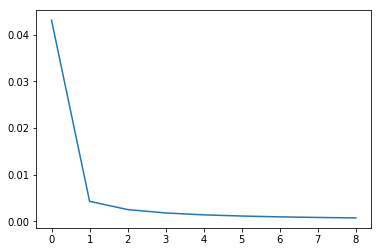

In [9]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

In [10]:
sess.run(rnn_outputs, feed_dict={x:np.zeros((200,5))})[2]


array([[-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.8256537 , -0.91269255, -0.9634326 ],
       [-0.8135929 , -0.

<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>Summary</b></font>

<br>
<br>
<br>
<font size='6' style="color:#00A6D6">  <b>References</b></font>

bibliography: Code: https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
sources: http://colah.github.io/posts/2015-08-Understanding-LSTMs/, www.deeplearningbook.org, Hands on Machine Learning with Scikit-Learn and Tensorflow by Aurelien Geron

a good tutorial, better than this one: https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767